# HW03 Fine-tuning

I recommend to work in [Lightning studio](https://lightning.ai/simecek/studios/fastai-transfer-learning-fine-tuning~01hv3p406bs3pebc3xm2qwtwz1) (and not Colab), because of preinstalled environment and permanent disk space.

## Data preparation

 1. You need to upload your dataset to the virtual machine. Since the dataset is relatively small, it's easiest to ZIP the data and use the 'Upload Files' button in the top left corner.
 2. You can unzip the data either through the Terminal or directly within the Jupyter Notebook using the command: `!unzip YOURFILENAME.zip`
 3. Optionally, organize the image files as shown in the schema below.

```
DATASET_NAME/
│
├── train/
│   ├── CATEGORY1/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   ├── CATEGORY2/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   └── ...
│
└── test/
    ├── CATEGORY1/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    ├── CATEGORY2/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    └── ...
```

If the data are organized in this form, you can obtain dataloaders as below. Otherwise, adapt `ImageDataLoaders` / `DataBlocks` accordingly.


In [ ]:
!unzip dataset_split.zip
!ls -la dataset_split/

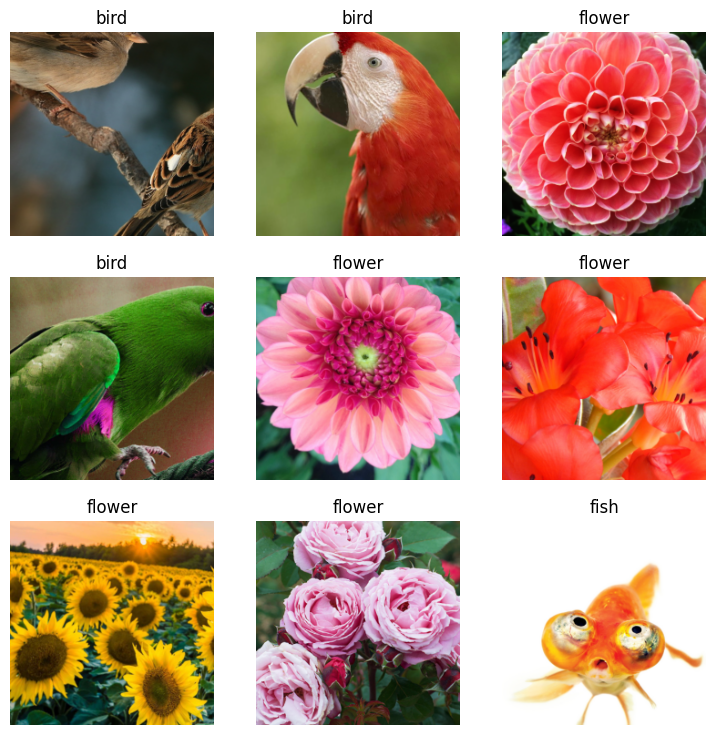

In [1]:
from fastai.vision.all import *
from pathlib import Path

path = Path('dataset_split') / 'train'

dls = ImageDataLoaders.from_folder(
    path,                 # Path to the train folder
    train='.',            # Use the entire train folder for splitting
    valid_pct=0.2,        # 20% of the data will be used for validation - as a protection against overfitting
    seed=42,              # Set a seed for reproducibility
    item_tfms=Resize(460),# Resize the images to 460x460 (or your desired size) - to ensure common size for further processing
    batch_tfms=aug_transforms(size=224, min_scale=0.75), # Data augmentation 
        # it is applied during the training for the whole batch together (more efective)
        # parameter size --> random crop of this size x size from the picture
        # min_scale=0.75: minimal zoom (e.g. 0.75 --> 75% of original size)
    bs=64                 # Batch size 64
)

dls.show_batch(max_n=9)

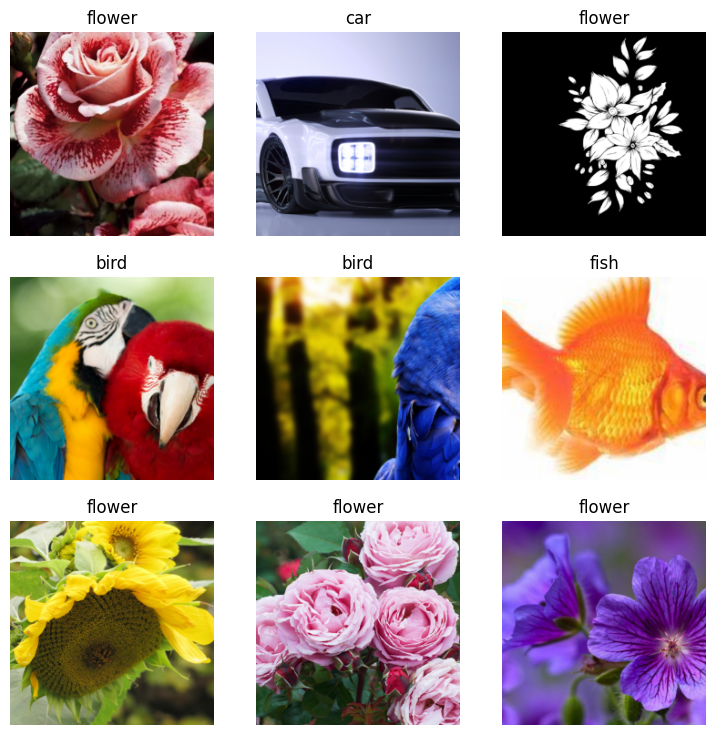

In [3]:
dls.show_batch(max_n = 9) # other random selection

In [4]:
import warnings

# to ignore the palette warnings
warnings.filterwarnings(
    "ignore",
    message="Palette images with Transparency expressed in bytes should be converted to RGBA images",
    category=UserWarning
)

## Train the model

  1. Choose a pretrained model.
  2. Determine the optimal learning rate using the learning rate finder.
  3. Fine-tune the pretrained model to adapt it to your dataset.

Regarding the model, use rather [something smaller](https://www.kaggle.com/code/jhoward/which-image-models-are-best) from `timm` package. Architectures like convexnet, resnet, vgg or mobilenet should be fine.

### Comparison of pretrained models
![Model comparison table](./model_comparison.png)

In [12]:
# TODO - you can change resnet18 to other architecture
# from timm import list_models
# list_models(pretrained=True)
pretrained_model = resnet18
learn = vision_learner(dls, pretrained_model, metrics=error_rate)

### Seeking of learning rate

SuggestedLRs(valley=0.0006918309954926372)

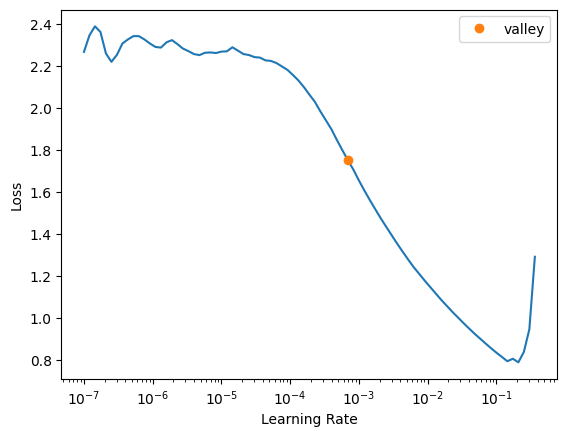

In [13]:
learn.lr_find()

In [14]:
lr =  0.0006918309954926372 # set optimal learning rate from the previous graph
epochs = 5 # set number of one-cycles for training, try to experiment a bit
# first choice was 5

### Fine-tuning

What happens during fine-tuning:

https://docs.google.com/presentation/d/1UAl21OYmGm-LunZ1vt0pLg44bkOrlRPZP-teW_PxnbM/edit?slide=id.g308b3ade2a8_0_382#slide=id.g308b3ade2a8_0_382
Slide 9, 13

**1. `vision_learner(dls, 'resnet18', metrics=error_rate)`**
- Downloads **pre-trained ResNet18** from ImageNet (14M+ images, 1000 categories)
- Removes the last layer (which classified 1000 ImageNet classes)
- Adds a **new last layer** for your 4 categories (bird, car, fish, flower)

**2. `learn.fine_tune(epochs, lr)`**
- **Fine-tuning** = retrains the model on your data
- Works in two phases:

**Phase 1 (1 epoch - automatic):**
- Freezes all layers except the last one
- Trains only the last layer on your data
- Slide 13: "Train the classifier, Freeze the pre-trained layers"

**Phase 2 (5 epochs - your parameter):**
- Unfreezes all layers
- Trains the entire model (but gently, to preserve pre-trained weights)
- Slide 13: "Fine-tuning, Update the weights of the pre-trained network"

**Result:**
A model that knows general patterns from ImageNet (edges, textures, shapes) + learned to specifically recognize your 4 categories.

In [15]:
# TODO - you can change resnet18 to other architecture (same as above)
learn = vision_learner(dls, pretrained_model, metrics=error_rate)
learn.fine_tune(epochs, lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.835932,0.394523,0.133333,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.567277,0.185777,0.058333,00:05
1,0.388860,0.087606,0.041667,00:05
2,0.297142,0.061031,0.033333,00:05
3,0.233353,0.052841,0.025000,00:06
4,0.182492,0.050997,0.025000,00:06


In [17]:
# Continue training without freezing (just regular fit)
learn.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.060225,0.026672,0.008333,00:05
1,0.039158,0.025014,0.016667,00:05


loss is decreasing more,
error_rate is slightly increasing, not too muc, only from 0,833% to 1,667% this can be only one image from 120 ones

### Evaluate the model's performance - confusion matrix

## Confusion Matrix

The confusion matrix shows how well the model classifies each category:
- **Diagonal values** (dark blue): correctly classified images
- **Off-diagonal values**: misclassifications (which categories are confused with each other)
- **Rows**: actual labels
- **Columns**: predicted labels

**How to read it:**
If you see a non-zero value at position (bird, flower), it means the model predicted "flower" when the actual label was "bird".

A good model has high values on the diagonal and zeros (or very low values) everywhere else.

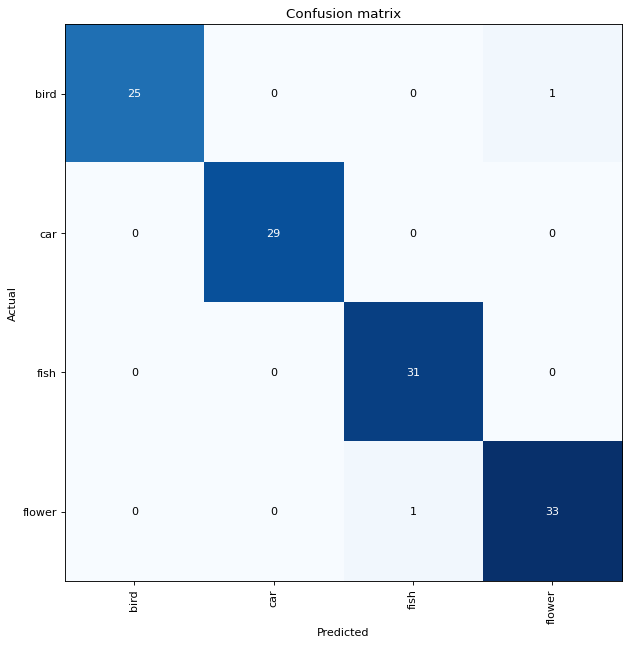

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

...and see the misclassified images in the validation set.

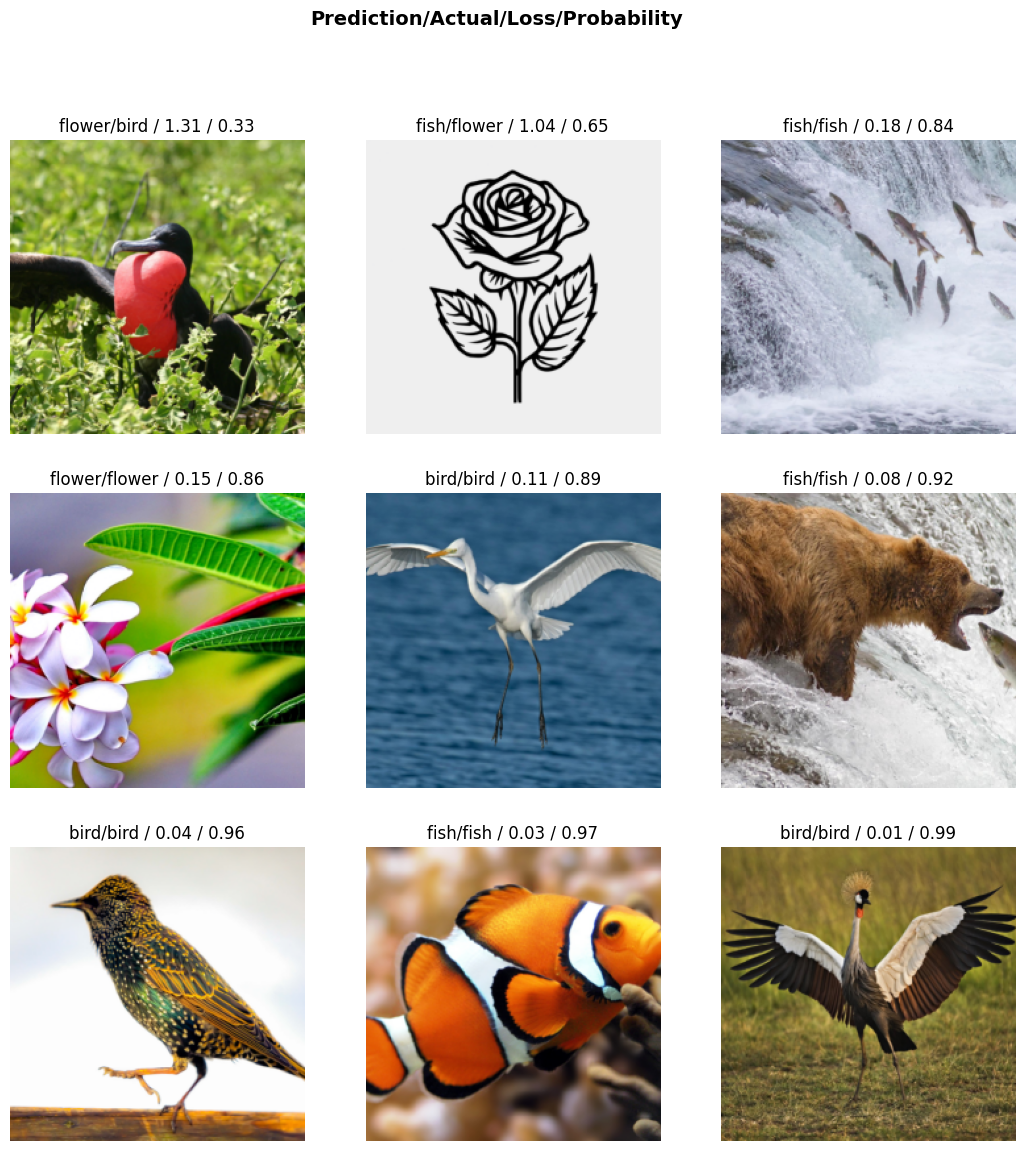

In [19]:
interp.plot_top_losses(9, figsize=(13,13))

Only the first 2 were clasiffied wrongly. Others are classified right, but with lower certainity. First number is loss, the second number is certainity of the answer.

If you see a mess, you might want to clean your data - there is a widget for that! It will list the most suspicios images (=highest loss) per set (train/valid) and category. Mark these images for deletion...

### Cleaning of the model - deletion of the images

...and now actually delete them.

After deleting the images, you need to rerun the entire notebook from the first cell to update the dataloaders, as they will point to deleted files.

## Test the model on a test set

### Test Set Evaluation

The next code prepares the test data for evaluation:

1. **`test_path = Path('dataset_split') / 'test'`** 
   - Sets the path to the test folder

2. **`get_image_files(test_path)`** 
   - Recursively finds all image files in test/bird/, test/car/, test/fish/, test/flower/

3. **`learn.dls.test_dl(...)`** 
   - Creates a DataLoader specifically for testing
   - Applies the same transformations (resize, normalization) as during training
   - Does NOT apply data augmentation (we want to test on original images)
   - Does NOT shuffle the images (order doesn't matter for testing)

The test set contains images the model has never seen during training or validation. 
This gives us the most realistic measure of how well the model will perform on new data.


In [20]:
# Create a test DataLoader
test_path = Path('dataset_split') / 'test'
test_dl = learn.dls.test_dl(get_image_files(test_path))

### Get Model Predictions

1. **`learn.get_preds(dl=test_dl)`**
   - Runs the model on all test images
   - Returns:
     - `preds`: probability distribution for each image (shape: [num_images, 4])
     - `targets`: not used here (would be targets if they were provided)

2. **`torch.argmax(preds, dim=1)`**
   - Converts probabilities to class predictions
   - For each image, selects the class with highest probability
   - Result: `pred_labels` contains predicted class indices (0=bird, 1=car, 2=fish, 3=flower)

In [21]:
# Get predictions
preds, targets = learn.get_preds(dl=test_dl)
pred_labels = torch.argmax(preds, dim=1)

In [31]:
preds[:10] # probabilities for categories for images

tensor([[1.0000e+00, 2.6116e-06, 7.9052e-09, 1.8112e-08],
        [9.9998e-01, 2.2518e-05, 1.8869e-07, 7.2281e-08],
        [1.0000e+00, 4.3915e-07, 1.0814e-10, 7.8486e-10],
        [9.9999e-01, 9.3999e-07, 4.5500e-06, 3.5798e-08],
        [2.4351e-02, 1.2885e-02, 9.5870e-01, 4.0631e-03],
        [9.9999e-01, 4.7301e-06, 1.6468e-07, 5.6105e-06],
        [1.0000e+00, 1.8845e-06, 1.1039e-07, 1.7528e-07],
        [1.0350e-02, 1.4916e-03, 4.4363e-03, 9.8372e-01],
        [9.9997e-01, 1.4531e-05, 9.3029e-06, 5.5609e-06],
        [9.9999e-01, 5.3980e-06, 4.7283e-07, 4.0416e-07]])

In [30]:
pred_labels[:10] # indexes of categories for images (0 = bird, 1 = car, 2 - fish, 3 = flower)

tensor([0, 0, 0, 0, 2, 0, 0, 3, 0, 0])

### Converting of predicted indexes to class names


In [33]:
class_names = learn.dls.vocab
#   - Gets the list of class names in order: ['bird', 'car', 'fish', 'flower']
#   - This is the same order used during training

In [39]:
pred_class_names = [class_names[i] for i in pred_labels]
#   - Converts predicted indices (0,1,2,3) to actual class names

In [41]:
# Convert predictions to class names
pred_class_names[:10]

['bird',
 'bird',
 'bird',
 'bird',
 'fish',
 'bird',
 'bird',
 'flower',
 'bird',
 'bird']

In [43]:
# Find out real class names
true_class_names = [Path(t).parent.name for t in test_dl.items]

### Error rate - comparison of prediction and reality

In [44]:
from statistics import mean

print("Test error rate:")
print(1 - mean([actual == predicted for actual, predicted in zip(true_class_names, pred_class_names)]))

Test error rate:
0.020000000000000018


In [47]:
0.020000000000000018*200

4.0000000000000036

Error rate = 2%, 4 images

## Let us save the model

In [49]:
learn.export('model.pkl')

Make sure to **download** `model.pkl` to your laptop, as you will need it later.